In [ ]:
import numpy as np
import torch
import pandas as pd
from itertools import product
from torch_geometric.data import Data

evt = "/mnt/data0/Trackml_dataset_100_events/Example_3/trackml_100_events/event000021000-"

def semi_fully_connected_graph(event_path):
    hits = pd.read_csv(event_path + 'hits.csv')
    #hits = hits[hits['volume_id'].isin([8,13,17])] #only consider barrel detector
    #hits = hits[hits['x'] > 0] #only consider right half of detector
    #hits = hits[hits['y'] > 0] #only consider top half of detector
    #hits = hits[hits['z'] > 0] #only consider front half of detector
    
    hits['layer_id'] = hits['volume_id']*10 + hits['layer_id']
    hits = hits.sort_values(by='layer_id')

    #Create graph object with node feature matrix
    graph = Data()
    
    graph.x = torch.tensor(np.arange(0,hits['hit_id'].to_numpy().shape[0],1))
    graph.hit_id = torch.tensor(hits['hit_id'].to_numpy())

    graph.pos = torch.empty(hits['x'].to_numpy().shape[0],3)
    graph.pos[:,0] = torch.tensor(hits['x'].to_numpy())
    graph.pos[:,1] = torch.tensor(hits['y'].to_numpy())
    graph.pos[:,2] = torch.tensor(hits['z'].to_numpy())
    
    edge_index = np.empty((2,1))

    all_layers = hits['layer_id'].unique()

    for i,layer in enumerate(all_layers):
        #Mask hits df to only include hits from current layer and next layer
        current_layer_hits = hits[hits['layer_id'] == layer].to_numpy()
        next_layer_hits = hits[hits['layer_id'] == all_layers[i+1]].to_numpy()
        
        #Get indices of hits in current and next layer
        current_layer_indices = np.nonzero(np.isin(hits['hit_id'].to_numpy(),current_layer_hits[:,0]))[0]
        next_layer_indices = np.nonzero(np.isin(hits['hit_id'].to_numpy(),next_layer_hits[:,0]))[0]

        #Create edges between hits in current and next layer
        edge_index = np.concatenate((edge_index,np.array(list(product(current_layer_indices,next_layer_indices))).T), axis=1)
    
        #Break if no next next layer exists
        if all_layers[i] == all_layers[-2]:
            break
        
        #Mask for next next layer, get indices and create edges between current and next next layer
        next_next_layer_hits = hits[hits['layer_id'] == all_layers[i+2]]
        next_next_layer_indices = np.nonzero(np.isin(hits['hit_id'].to_numpy(),next_next_layer_hits))[0]
        edge_index = np.concatenate((edge_index,np.array(list(product(next_layer_indices,next_next_layer_indices))).T), axis=1)
    	

    graph.edge_index = torch.tensor(edge_index).to(torch.int64)
    print("Num nodes:",graph.x.shape)
    print("Num edges:",graph.edge_index.shape)
    print("Total number of layers:",hits['layer_id'].unique().shape[0])

    return graph

graph = semi_fully_connected_graph(evt)
torch.save(graph,'hit_graph_barrel_event000021000.pyg')

KeyboardInterrupt: 

In [1]:
import random
import torch
import numpy as np

graph = torch.load('/home/mue/karres/git/TrackletGraphs/testing_stuff/pyg_files/hit_graph_tiny_event000021000.pyg')
#Random filter to remove edges and unconnected nodes
def random_filter(graph, p=0.2,seed=42):
    n_edges = graph.edge_index.shape[1]
    print('Number of edges before filter:',n_edges)

    edge_keys = [key for key, value in graph.items() if isinstance(value, torch.Tensor) and value.dim() == 1 and value.shape[0] == n_edges]

    assert p >= 0 and p <= 1, 'p must be between 0 and 1'
    if p > 0.5:
        random.seed(seed)
        keep_edges = random.sample(range(0,graph.edge_index.shape[1]),int(graph.edge_index.shape[1]*(1-p)))
        graph.edge_index = torch.from_numpy(np.take(graph.edge_index.numpy(),keep_edges,axis=1))
        n_filtered = n_edges - int(n_edges*(1-p))
        for key in edge_keys:
            graph[key] = torch.from_numpy(np.take(graph[key].numpy(),keep_edges,axis=0))

    else:
        random.seed(seed)
        remove_edges = random.sample(range(0,graph.edge_index.shape[1]),int(graph.edge_index.shape[1]*p))
        graph.edge_index = torch.from_numpy(np.delete(graph.edge_index.numpy(),remove_edges,axis=1))
        n_filtered = int(n_edges*p)
        for key in edge_keys:
            graph[key] = torch.from_numpy(np.delete(graph[key].numpy(),remove_edges,axis=0))

    print('Number of edges after filter:',graph.edge_index.shape[1])
    print('Delta:',n_filtered)
    return graph

graph = random_filter(graph)
torch.save(graph,'/home/mue/karres/git/TrackletGraphs/testing_stuff/pyg_files/hit_graph_tiny_event000021000_filtered.pyg')

print(graph)

Number of edges before filter: 11908211
Number of edges after filter: 9526569
Delta: 2381642
Data(x=[8560], hit_id=[8560], pos=[8560, 3], edge_index=[2, 9526569])


In [3]:
import torch
import torch_geometric.transforms as T

graph = torch.load('hit_graph_tiny_event000021000.pyg')
print(graph)

linegraph_trafo = T.LineGraph()
print(linegraph_trafo(graph))

Data(x=[8560], hit_id=[8560], pos=[8560, 3], edge_index=[2, 11908211])


KeyboardInterrupt: 

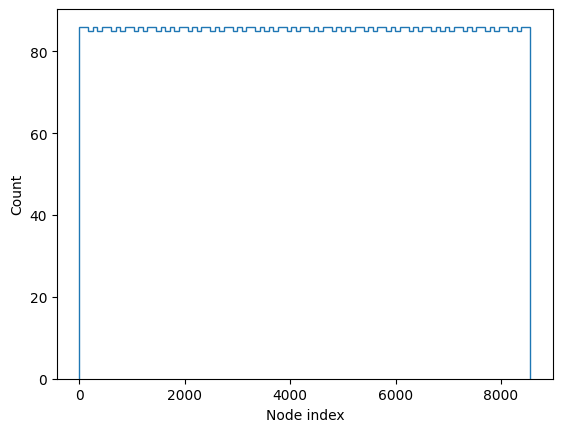

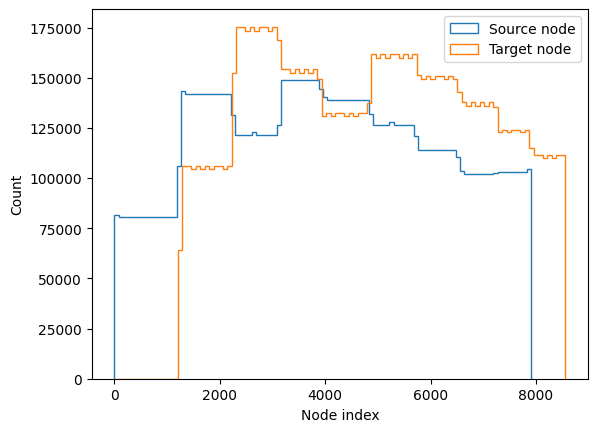

In [4]:
import matplotlib.pyplot as plt

plt.hist(graph.x.numpy(),bins=100, histtype='step')
plt.ylabel('Count')
plt.xlabel('Node index')
plt.show()

plt.hist(graph.edge_index.numpy()[0,:],bins=100, label='Source node', histtype='step')
plt.hist(graph.edge_index.numpy()[1,:],bins=100 ,label='Target node', histtype='step')
plt.ylabel('Count')
plt.xlabel('Node index')
plt.legend()
plt.show()

In [2]:
from itertools import combinations
import torch
import torch_geometric.transforms as T
from torch_geometric.data import Data

linegraph_trafo = T.LineGraph()

def build_fc_graph(n_nodes):
    '''
    Builds a fully connected graph with n_nodes, no self-loops and only edges in one direction
    '''
    graph = Data()
    graph.x = torch.tensor(range(n_nodes))
    graph.num_nodes = n_nodes
    
    edge_index_list = list(combinations(range(n_nodes),r=2))
    graph.edge_index = torch.tensor(edge_index_list).T
    return graph

def iterate_linegraph(graph, n, filter=False): #n is the number of tracklet iterations
    print("Original graph:",graph)
    for i in range(n):
        graph = linegraph_trafo(graph)
        print("Linegraph:",graph)
        if graph.edge_index != None: 
            if filter:
                graph = random_filter(graph, p=0.01)
            print("Linegraph iteration",i,":",graph)
            print()
            continue
        
iterate_linegraph(build_fc_graph(10),3,filter=False)

Original graph: Data(x=[10], num_nodes=10, edge_index=[2, 45])
Linegraph: Data(num_nodes=45, edge_index=[2, 120])
Linegraph iteration 0 : Data(num_nodes=45, edge_index=[2, 120])

Linegraph: Data(num_nodes=120, edge_index=[2, 210])
Linegraph iteration 1 : Data(num_nodes=120, edge_index=[2, 210])

Linegraph: Data(num_nodes=210, edge_index=[2, 252])
Linegraph iteration 2 : Data(num_nodes=210, edge_index=[2, 252])



Number of edges before filter: 10
Number of edges after filter: 8
Delta: 2
Total number of nodes: 5
Number of connected nodes: 5
Plots for 5 FC nodes done!
Number of edges before filter: 45
Number of edges after filter: 36
Delta: 9
Total number of nodes: 10
Number of connected nodes: 10
Plots for 10 FC nodes done!
Number of edges before filter: 105
Number of edges after filter: 84
Delta: 21
Total number of nodes: 15
Number of connected nodes: 15
Plots for 15 FC nodes done!
Number of edges before filter: 190
Number of edges after filter: 152
Delta: 38
Total number of nodes: 20
Number of connected nodes: 20
Plots for 20 FC nodes done!
Number of edges before filter: 300
Number of edges after filter: 240
Delta: 60
Total number of nodes: 25
Number of connected nodes: 25
Plots for 25 FC nodes done!


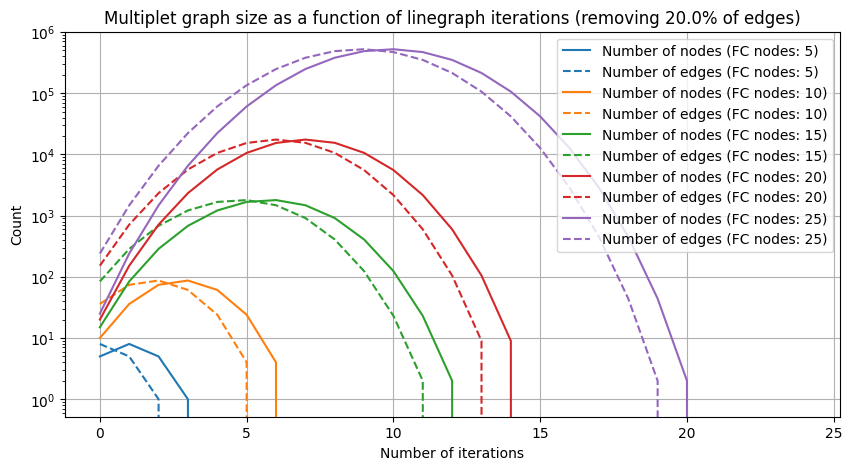

In [ ]:
import matplotlib.pyplot as plt 

def plot_multiplet_graph_size(num_fc_nodes, num_iterations):
    '''
    Plots the number of nodes and edges in a multiplet graph as a function of linegraph iterations
    Input: num_fc_nodes - list of number of nodes in the fully connected graph
           num_iterations - number of linegraph iterations
    '''
    prob = 0.2
    if type(num_fc_nodes) != list:
        num_fc_nodes = [num_fc_nodes]

    fig, axs = plt.subplots(1,1, figsize=(10,5))
    axs.set_xlabel('Number of iterations')
    axs.set_ylabel('Count')
    axs.grid()
    axs.set_yscale('log')
    
    axs.set_title(f'Multiplet graph size as a function of linegraph iterations (removing {prob*100}% of edges)')

    for nodes in num_fc_nodes:
        hit_graph = build_fc_graph(nodes)
        hit_graph = random_filter(hit_graph, p=prob)
        num_nodes = [hit_graph.num_nodes]
        num_edges = [hit_graph.edge_index.shape[1]]

        for i in range(num_iterations-1):
            linegraph = linegraph_trafo(hit_graph)

            if linegraph.edge_index == None or linegraph.num_nodes == 0:
                for j in range(num_iterations-i-1):
                    num_nodes.append(0)
                    num_edges.append(0)
                break

            num_nodes.append(linegraph.num_nodes)
            num_edges.append(linegraph.edge_index.shape[1])
            hit_graph = linegraph

        p = axs.plot(range(num_iterations),num_nodes, label=f'Number of nodes (FC nodes: {nodes})')
        c = p[0].get_color()
        axs.plot(range(num_iterations),num_edges, label=f'Number of edges (FC nodes: {nodes})', linestyle='--', color=c)
        print(f'Plots for {nodes} FC nodes done!')

    axs.legend()
    plt.savefig(f'multiplet_graph_size_p{prob}.png')
    plt.show()

plot_multiplet_graph_size([5,10,15,20,25],25)


In [ ]:
import glob
import torch
import numpy as np

#Get edgewise efficiency and purity for a metric learning graph
dir_metricl = '/mnt/data1/karres/Example_3/metric_learning/trainset/'
dir_filter = '/mnt/data1/karres/Example_3/filter/trainset/'

def get_eff_pur(dir):
    files = glob.glob(dir + '*.pyg')
    eff, pur = [], []

    for file in files:
        graph = torch.load(file)
        #Eff = number of track_edges in edge_index / number of edges in track_edges
        #Pur = number of track_edges in edge_index / number of edges in edge_index

        edge_index = graph.edge_index.numpy()
        track_edges = graph.track_edges.numpy()

        #Sort both arrays such that the lower index is on top
        edge_index = np.sort(edge_index, axis=0)
        track_edges = np.sort(track_edges, axis=0)

        edge_index_set = set(map(tuple,edge_index.T))
        overlap = sum([tuple(edge) in edge_index_set for edge in track_edges.T])

        eff.append(overlap/track_edges.shape[1])
        pur.append(overlap/edge_index.shape[1])
    
    print(f'Efficiency: {np.mean(eff)}')
    print(f'Purity: {np.mean(pur)}')

print('Metric learning graphs:')
get_eff_pur(dir_metricl)
print('Filtered graphs:')
get_eff_pur(dir_filter)

In [16]:
import torch

def apply_mask_to_graph(graph, mask, mask_type='node'):
    '''
    Removes nodes or edges from the graph based based on a mask and reindexes edge_index and track_edges if nodes are removed
    Input: graph - pytorch geometric data object
           mask - boolean mask for nodes or edge features
           mask_type - 'node' or 'edge'
    '''
    mask_len = mask.size(0)
    num_nodes = graph.num_nodes
    num_edges = graph.edge_index.size(1)

    assert (mask_type == 'node' and mask_len == num_nodes) or (mask_type == 'edge' and mask_len == num_edges), 'Mask length does not match number of nodes or edges'

    if mask_type == 'node':
        print('Filtering node features')
        return filter_node_feature(graph, mask)
    elif mask_type == 'edge':
        print('Filtering edge features')
        return filter_edge_feature(graph, mask)
    else:
        raise ValueError('Invalid mask type')

def filter_node_feature(graph, mask):
    #Create a mapping from old indices to new indices
    mapping = -torch.ones(graph.hit_id.shape[0], dtype=torch.long)  # Initialize mapping
    mapping[mask] = torch.arange(mask.sum())  # Assign new indices

    #Filter edges where both nodes are in the mask
    edge_mask = mask[graph.edge_index[0]] & mask[graph.edge_index[1]]
    filtered_edge_index = graph.edge_index[:, edge_mask]

    #Remap edges to new indices
    new_edge_index = mapping[filtered_edge_index]

    #Filter all node and edge features and create new graph
    node_feature_dict = {
        key: value[mask] for key, value in graph.items()
        if isinstance(value, torch.Tensor) and value.dim() == 1 and 
        value.shape[0] == int(graph.num_nodes)} # Filters only node features
 
    edge_feature_dict = {
        key: value[edge_mask] for key, value in graph.items()
        if isinstance(value, torch.Tensor) and value.dim() == 1 and
        value.shape[0] == graph.edge_index.shape[1]} # Filters only edge features
    
    #Filter track edges if they exist
    if 'track_edges' in graph.keys():
        te_mask = mask[graph.track_edges[0]] & mask[graph.track_edges[1]]
        filtered_track_edges = graph.track_edges[:, te_mask]
        new_track_edges = mapping[filtered_track_edges]

        track_edge_feature_dict = {
            key: value[te_mask] for key, value in graph.items() 
            if isinstance(value, torch.Tensor) and value.dim() == 1 and 
            value.shape[0] == graph.track_edges.shape[1]} # Filters only track edge features
        
    graph.update(node_feature_dict)
    graph.update(edge_feature_dict)
    graph.update(track_edge_feature_dict)
    graph.edge_index = new_edge_index
    graph.track_edges = new_track_edges
    graph.truth_map = build_truth_map(graph.edge_index, graph.track_edges)
    graph.num_nodes = mask.sum() 
    return graph

def build_truth_map(edge_index, track_edges):
    edge_index_exp = edge_index.T.unsqueeze(0)  # Shape (1, n, 2)
    track_edges_exp = track_edges.T.unsqueeze(1)  # Shape (m, 1, 2)

    # Compare all pairs at once
    matches = torch.all(edge_index_exp == track_edges_exp, dim=2)  # Shape (m, n), True where matches exist

    # Get the first matching index for each row in B, or -1 if no match
    truth_map = torch.where(matches.any(dim=1), matches.int().argmax(dim=1), torch.tensor(-1))
    return truth_map


def filter_edge_feature(graph, mask):
    raise NotImplementedError

metric_learning_graph = torch.load("/mnt/data1/karres/Example_3/filter/testset/event['000021010'].pyg")
mask = torch.isin(metric_learning_graph.region, torch.tensor([3,4]))

print(metric_learning_graph)
filtered_graph = filter_node_feature(metric_learning_graph, mask)
print(filtered_graph)

def flip_edges(graph):
    '''
    Flips the direction of an edge, if the receiving node is closer to the origin
    '''
    r,z = graph.r, graph.z
    d = torch.sqrt(r**2 + z**2)

    d_source = d[graph.edge_index[0]]
    d_target = d[graph.edge_index[1]]
    
    swap_mask = d_target < d_source  # Boolean mask

    # Perform swapping using advanced indexing (efficient in-place swap)
    graph.edge_index[0, swap_mask], graph.edge_index[1, swap_mask] = graph.edge_index[1, swap_mask], graph.edge_index[0, swap_mask]
    graph.edge_index = torch.unique(graph.edge_index, dim=1)  # Remove duplicates
    
    return graph

DataBatch(x=[14349], edge_index=[2, 20900], y=[20900], region=[14349], ly=[14349], gphi=[14349], hit_id=[14349], cell_count=[14349], cell_val=[14349], module_index=[14349], phi=[14349], lx=[14349], lz=[14349], geta=[14349], eta=[14349], r=[14349], leta=[14349], weight=[14349], z=[14349], lphi=[14349], track_edges=[2, 13087], radius=[13087], pt=[13087], nhits=[13087], particle_id=[13087], config=[2], event_id=[1], num_nodes=14349, batch=[14349], truth_map=[13087], weights=[20900], ptr=[2], scores=[20900])
DataBatch(x=[7619], edge_index=[2, 9726], y=[9726], region=[7619], ly=[7619], gphi=[7619], hit_id=[7619], cell_count=[7619], cell_val=[7619], module_index=[7619], phi=[7619], lx=[7619], lz=[7619], geta=[7619], eta=[7619], r=[7619], leta=[7619], weight=[7619], z=[7619], lphi=[7619], track_edges=[2, 6517], radius=[6517], pt=[6517], nhits=[6517], particle_id=[6517], config=[2], event_id=[1], num_nodes=7619, batch=[7619], truth_map=[6517], weights=[9726], ptr=[2], scores=[9726])


In [4]:
import torch
import gc
from torch_geometric.data import Data

graph = Data(edge_index = torch.tensor([[1,2,3,4],[2,3,4,1]]))

def add_metagraph(graph):
    '''
    Add a metagraph to the graph
    Needs to be updated after each linegraph iteration
    '''
    assert hasattr(graph, 'edge_index'), 'Edge index does not exist in graph'
    
    graph.metagraph = [{graph.edge_index[0,i].item(), graph.edge_index[1,i].item()} for i in range(graph.edge_index.shape[1])]
    return graph

def update_metagraph(graph):
    '''
    Updates the metagraph after each linegraph iteration
    '''
    assert hasattr(graph, 'metagraph'), 'Metagraph does not exist in graph'
    assert hasattr(graph, 'edge_index'), 'Edge index does not exist in graph'

    new_metagraph =  []
    for tracklet in graph.edge_index.T:
        trackletA = graph.metagraph[tracklet[0]]
        trackletB = graph.metagraph[tracklet[1]]
        new_tracklet = trackletA|trackletB
        new_metagraph.append(new_tracklet)
    graph.metagraph = new_metagraph
    return graph

def gpu_update_metagraph(graph):
    '''
    Efficiently updates the metagraph after each linegraph iteration
    '''
    assert hasattr(graph, 'metagraph'), 'Metagraph does not exist in graph'
    assert hasattr(graph, 'edge_index'), 'Edge index does not exist in graph'

    edge_index = graph.edge_index.cpu().numpy()  # Move to CPU for efficient indexing
    metagraph_np = graph.metagraph  # Assuming metagraph is already a CPU list of sets

    # Efficiently compute new metagraph using list comprehension
    new_metagraph = [metagraph_np[a] | metagraph_np[b] for a, b in edge_index.T]

    graph.metagraph.extend(new_metagraph)  # Store the updated metagraph
    return graph

def gpu_random_filter(graph,p):
    '''
    Randomly removes p percent of edges from the graph
    Optimized for usage on GPU
    '''

    n_edges = graph.edge_index.shape[1]
    remove_m_edges = int(n_edges*p)
    if remove_m_edges == 0:
        return graph
    
    remove_indices = torch.randperm(n_edges,device=graph.edge_index.device)[:remove_m_edges]

    mask = torch.ones(n_edges, dtype=torch.bool, device=graph.edge_index.device)
    mask[remove_indices] = False

    graph.edge_index = graph.edge_index[:,mask]

    return graph

def get_incidence_matrices(edge_index, num_nodes):
    num_edges = edge_index.shape[1]

    device = edge_index.device
    
    B_minus = torch.sparse_coo_tensor(
        indices=torch.stack((edge_index[0,:], torch.arange(0,num_edges, device=device))), values=torch.ones(num_edges, device=device), size=(num_nodes, num_edges), dtype=torch.float
        )
    B_plus = torch.sparse_coo_tensor(
        indices=torch.stack((edge_index[1,:], torch.arange(0,num_edges, device=device))), values=torch.ones(num_edges, device=device), size=(num_nodes, num_edges), dtype=torch.float
        )
    return B_plus, B_minus

def line_graph(graph):
    B_plus, B_minus = get_incidence_matrices(graph.edge_index, graph.num_nodes)
    mat = torch.sparse.mm(B_plus.transpose(0,1), B_minus)

    return Data(edge_index=mat.indices(), num_nodes=graph.edge_index.shape[1], **{k: v for k, v in graph if k not in ["edge_index", "num_nodes"]})

Filtering with p=0.05
Loaded graph in 0.0062 seconds
Filtering node features
Preprocessed graph in 0.3508 seconds
Transferred edge index to GPU in 0.0203 seconds
Filtering with p=0.075
Loaded graph in 0.0038 seconds
Filtering node features
Preprocessed graph in 0.2233 seconds
Transferred edge index to GPU in 0.0002 seconds
Filtering with p=0.1
Loaded graph in 0.0038 seconds
Filtering node features
Preprocessed graph in 0.2220 seconds
Transferred edge index to GPU in 0.0002 seconds
Filtering with p=0.2
Loaded graph in 0.0041 seconds
Filtering node features
Preprocessed graph in 0.2234 seconds
Transferred edge index to GPU in 0.0002 seconds
Filtering with p=0.3
Loaded graph in 0.0037 seconds
Filtering node features
Preprocessed graph in 0.2220 seconds
Transferred edge index to GPU in 0.0002 seconds
Filtering with p=0.4
Loaded graph in 0.0035 seconds
Filtering node features
Preprocessed graph in 0.2257 seconds
Transferred edge index to GPU in 0.0002 seconds
Filtering with p=0.5
Loaded gra

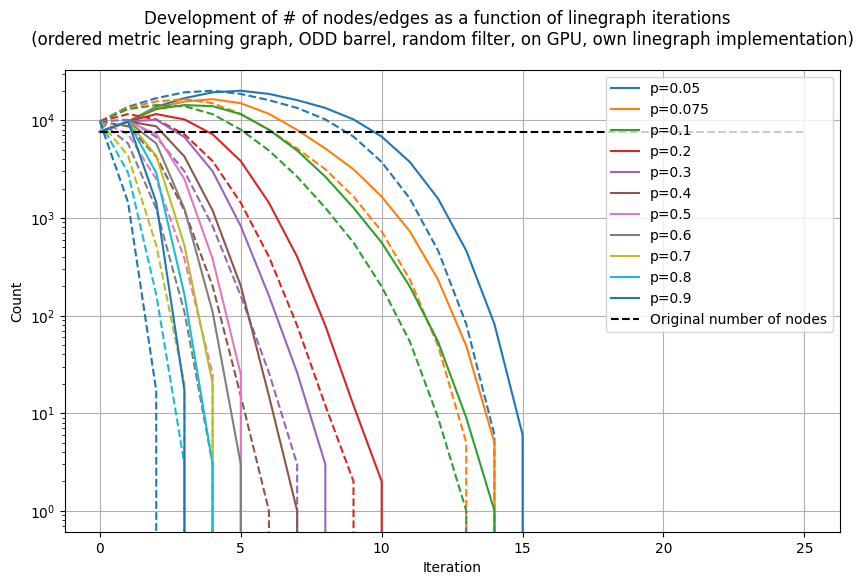

In [ ]:
import time
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch_geometric.data import Data
from torch_geometric.transforms import LineGraph
import pandas as pd

save_as, res = "/home/mue/karres/git/TrackletGraphs/testing_stuff/plots/odd_barrel_linegraph_size_own_linegraph.pdf", 500

linegraph_trafo = LineGraph()

fig, axs = plt.subplots(1,1, figsize=(10,6))
fig.suptitle('Development of # of nodes/edges as a function of linegraph iterations \n (ordered metric learning graph, ODD barrel, random filter, on GPU, own linegraph implementation)')
axs.set_xlabel('Iteration')
axs.set_ylabel('Count')
axs.set_yscale('log')
axs.grid()

times = []
#probs = [0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.025,0.01,0]
probs = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.075,0.05]
probs.reverse()

for p in probs:
    print('=======================================')
    print(f'Filtering with p={p}')
    print('=======================================')
    
    start = time.perf_counter()

    metric_learning_graph = torch.load("/mnt/data1/karres/Example_3/filter/testset/event['000021010'].pyg")

    load_end = time.perf_counter()
    print(f'Loaded graph in {load_end-start:.4f} seconds')

    prep_start = time.perf_counter()

    metric_learning_graph = flip_edges(metric_learning_graph) #flip edges if target node is closer to origin
    barrel_only_graph = apply_mask_to_graph(metric_learning_graph, torch.isin(metric_learning_graph.region, torch.tensor([3,4]))) #only consider the barrel detector
    #barrel_only_graph = metric_learning_graph
    #barrel_only_graph = gpu_random_filter(barrel_only_graph, p=p) #randomly remove edges
    barrel_only_graph = add_metagraph(barrel_only_graph) #create metagraph

    prep_end = time.perf_counter()
    print(f'Preprocessed graph in {prep_end-prep_start:.4f} seconds')

    device = torch.device('cpu')

    transfer_start = time.perf_counter()

    barrel_only_graph.edge_index.to(device)
    
    transfer_end = time.perf_counter()
    print(f'Transferred edge index to GPU in {transfer_end-transfer_start:.4f} seconds')

    n_nodes = [barrel_only_graph.num_nodes]
    n_edges = [barrel_only_graph.edge_index.shape[1]]

    lg_times = []
    f_times = []
    u_times = []

    for i in range(100):
        if barrel_only_graph.edge_index is None or barrel_only_graph.num_nodes == 0:
            iteration = i
            break
        if not barrel_only_graph.edge_index.is_cuda:
            barrel_only_graph.edge_index = barrel_only_graph.edge_index.to(device)

        linegraph_start = time.perf_counter()
        #graph = linegraph_trafo(barrel_only_graph)
        graph = barrel_only_graph.clone()
        graph.edge_index, graph.num_nodes = line_graph(graph.edge_index, graph.num_nodes)
        linegraph_end = time.perf_counter()
        graph = gpu_random_filter(graph, p=p)
        filter_end = time.perf_counter()
        graph = gpu_update_metagraph(graph)
        update_end = time.perf_counter()
        barrel_only_graph = graph

        n_nodes.append(graph.num_nodes)
        n_edges.append(graph.edge_index.shape[1])

        lg_times.append(linegraph_end-linegraph_start)
        f_times.append(filter_end-linegraph_end)
        u_times.append(update_end-filter_end)

    torch.cuda.synchronize()
    end = time.perf_counter()

    total_time = end-start
    prep_time = prep_end-prep_start
    transfer_time = transfer_end-transfer_start
    
    time_data = {
        'p':p,
        'total_time':total_time,
        'prep_time':prep_time,
        'transfer_time':transfer_time,
        'mean_linegraph_time':np.mean(lg_times),
        'std_linegraph_time':np.std(lg_times),
        'mean_filter_time':np.mean(f_times),
        'std_filter_time':np.std(f_times),
        'mean_update_time':np.mean(u_times),
        'std_update_time':np.std(u_times),
        'num_iterations':iteration
    }

    for idx,t in enumerate(lg_times):
        time_data[f'linegraph_{idx+1}_time'] = t
    for idx,t in enumerate(f_times):
        time_data[f'filter_{idx+1}_time'] = t
    for idx,t in enumerate(u_times):
        time_data[f'update_{idx+1}_time'] = t

    times.append(time_data)

    plot = axs.plot(range(len(n_nodes)),n_nodes, label=f'p={p}')
    c = plot[0].get_color()
    axs.plot(range(len(n_edges)),n_edges, linestyle='--', color=c)
    axs.legend()
    plt.savefig(save_as, dpi=res)
    if 0.1 <= p <= 0.9:
        torch.save(barrel_only_graph, f'/home/mue/karres/git/TrackletGraphs/testing_stuff/pyg_files/odd_barrel_p{int(p*100):02d}_own_linegraph.pyg')
        
axs.hlines(metric_learning_graph.to('cpu').num_nodes, 0, 25, color='black', linestyles='--', label='Original number of nodes')
axs.legend()
plt.savefig(save_as, dpi=res)
plt.show()

df = pd.DataFrame(times)
df.to_csv('/home/mue/karres/git/TrackletGraphs/testing_stuff/plots/odd_barrel_times_own_linegraph.csv')

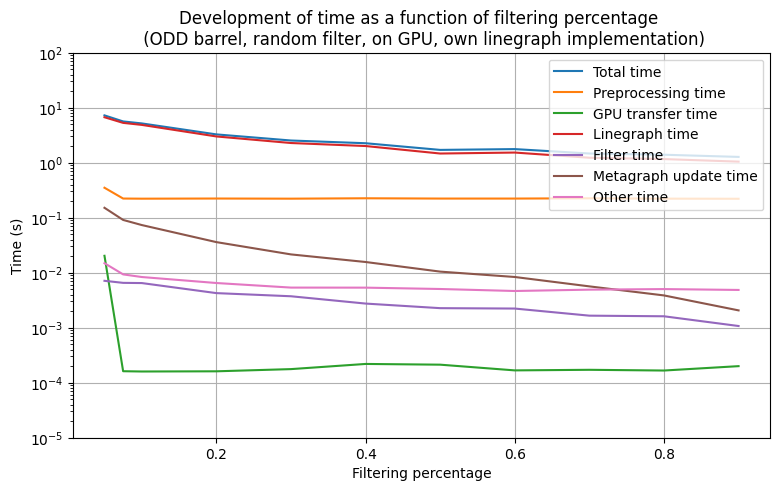

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

times_df = pd.read_csv('/home/mue/karres/git/TrackletGraphs/testing_stuff/plots/odd_barrel_times_own_linegraph.csv')
p = times_df['p']
total = times_df['total_time']
prep = times_df['prep_time']
transfer = times_df['transfer_time']
linegraph = times_df['mean_linegraph_time']*times_df['num_iterations']
filter = times_df['mean_filter_time']*times_df['num_iterations']
update = times_df['mean_update_time']*times_df['num_iterations']

fig, axs = plt.subplots(1,1, figsize=(9,5))

axs.plot(p, total, label='Total time')
axs.plot(p, prep, label='Preprocessing time')
axs.plot(p, transfer, label='GPU transfer time')
axs.plot(p, linegraph, label='Linegraph time')
axs.plot(p, filter, label='Filter time')
axs.plot(p, update, label='Metagraph update time')
axs.plot(p, total-prep-transfer-linegraph-filter-update, label='Other time')
axs.set_title('Development of time as a function of filtering percentage \n (ODD barrel, random filter, on GPU, own linegraph implementation)')
axs.set_xlabel('Filtering percentage')
axs.set_ylabel('Time (s)')
axs.grid()
axs.set_yscale('log')
axs.set_ylim(10**-5, 100)
axs.legend()
fig.savefig('/home/mue/karres/git/TrackletGraphs/testing_stuff/plots/odd_barrel_times_own_linegraph.pdf', dpi=500)
plt.show()

In [50]:
from itertools import chain
import torch
import time

def produce_longest_track_candidate_legacy(flattened_metagraph):
    longest_track_candidate = max(flattened_metagraph, key=len)
    flattened_metagraph = [s for s in flattened_metagraph if s.isdisjoint(longest_track_candidate)]

    return longest_track_candidate, flattened_metagraph

def produce_longest_track_candidate(flattened_metagraph, seen):
    longest_track_candidate = None
    for s in flattened_metagraph:
        if s.isdisjoint(seen):
            if longest_track_candidate is None or len(s) > len(longest_track_candidate):
                longest_track_candidate = s
    
    if longest_track_candidate is not None:
        seen.update(longest_track_candidate)
        flattened_metagraph = [s for s in flattened_metagraph if s.isdisjoint(longest_track_candidate)]

    return longest_track_candidate, flattened_metagraph

def get_all_track_candidates(metagraph):
    if any(isinstance(item, list) for item in metagraph): 
        flattened_metagraph = list(chain(*metagraph))
    else:
        flattened_metagraph = metagraph
        
    track_candidates1 = []
    track_candidates2 = []
    seen = set()

    start1 = time.perf_counter()
    while flattened_metagraph:
        largest_set, flattened_metagraph = produce_longest_track_candidate(flattened_metagraph, seen)
        
        if largest_set is not None:
            track_candidates1.append(largest_set)
    end1 = time.perf_counter()

    if any(isinstance(item, list) for item in metagraph): 
        flattened_metagraph = list(chain(*metagraph))
    else:
        flattened_metagraph = metagraph

    start2 = time.perf_counter()
    while flattened_metagraph:
        largest_set, flattened_metagraph = produce_longest_track_candidate_legacy(flattened_metagraph)
        if largest_set is not None:
            track_candidates2.append(largest_set)   

    end2 = time.perf_counter()

    print(f'New method took {end1-start1:.4f} seconds')
    print(f'Old method took {end2-start2:.4f} seconds')

    return track_candidates1, track_candidates2

graph = torch.load('/home/mue/karres/git/TrackletGraphs/testing_stuff/pyg_files/odd_barrel_p50_full_linegraph.pyg')
print(graph)
track_candidates = get_all_track_candidates(graph.metagraph)

#print("Total number of nodes in track candidates:",sum([len(s) for s in track_candidates]))
#print("Total number of nodes in metagraph:",sum([len(s) for s in graph.metagraph]))

print("Delta:",sum([len(s) for s in track_candidates[0]]) - sum([len(t) for t in track_candidates[1]]))

import matplotlib.pyplot as plt

# Get sizes of each set
sizes = [len(s) for s in graph.metagraph]
'''
# Plot histogram
plt.hist(sizes, bins=range(1, max(sizes) + 2), align='left', edgecolor='black')

plt.xlabel("Tracklet Size")
plt.ylabel("Frequency")
plt.title("Histogram of Tracklet Sizes")
plt.xticks(range(1, max(sizes) + 1))
plt.yscale('log')
plt.show()
'''

def are_sets_disjoint(sets_list):
    seen = set()
    for s in sets_list:
        if not seen.isdisjoint(s):  # Check if there's an intersection
            return False
        seen.update(s)  # Add elements to the seen set
    return True

print(are_sets_disjoint(track_candidates[0]))

DataBatch(edge_index=[2, 0], y=[9726], region=[7619], ly=[7619], gphi=[7619], hit_id=[7619], cell_count=[7619], cell_val=[7619], module_index=[7619], phi=[7619], lx=[7619], lz=[7619], geta=[7619], eta=[7619], r=[7619], leta=[7619], weight=[7619], z=[7619], lphi=[7619], track_edges=[2, 6517], radius=[6517], pt=[6517], nhits=[6517], particle_id=[6517], config=[2], event_id=[1], num_nodes=0, batch=[7619], truth_map=[6517], weights=[9726], ptr=[2], scores=[9726], metagraph=[20613])
New method took 2.2233 seconds
Old method took 0.9538 seconds
Delta: 0
True


In [51]:
import h5py

def load_metagraph_from_hdf5(filename="sets_efficient.h5"):
    """
    Load a metagraph stored efficiently in an HDF5 file.
    """
    
    with h5py.File(filename, "r") as f:
        flat_data = f["data"][:]
        indices = f["indices"][:]
    
    # Reconstruct sets using index offsets
    sets_list = [set(flat_data[indices[i]:indices[i+1]]) for i in range(len(indices) - 1)]
    
    return sets_list

framework_metagraph = load_metagraph_from_hdf5('/home/mue/karres/git/TrackletGraphs/testing_stuff/pyg_files/track_candidates.h5')

assert framework_metagraph == track_candidates[0], 'Metagraphs do not match'


In [42]:
import torch
import gc

def line_graph(edge_index, num_nodes):
    '''
    Input: edge_index tensor on cuda
    Output: edge index of line graph
    '''
    
    num_edges = edge_index.size(1)
    incidence_matrix = get_incidence_matrix(edge_index, num_nodes) #sparse incidence matrix B(G)
    
    inc_mat_t = torch.sparse_coo_tensor(
        indices=incidence_matrix._indices()[[1,0]],
        values=incidence_matrix._values(),
        size=(num_edges, num_nodes),
        device=edge_index.device
    )   
    mat = torch.sparse.mm(inc_mat_t, incidence_matrix).coalesce()

    identity_indices = torch.arange(num_edges, device=edge_index.device).repeat(2,1)
    identity_values = -2*torch.ones(num_edges, device=edge_index.device)
    identity_matrix = torch.sparse_coo_tensor(identity_indices, identity_values, (num_edges, num_edges), device=edge_index.device).coalesce()

    mat = mat + identity_matrix
    mat = mat.coalesce()

    indices = mat.indices()
    values = mat.values()
    mask = indices[0] < indices[1]  # Sparse filtering, no dense operation!
    mat = torch.sparse_coo_tensor(indices[:, mask], values[mask], mat.shape, device=edge_index.device).coalesce()

    #upper_triangle_mask = torch.triu(torch.ones_like(mat.to_dense()))
    #upper_triangle_mask = torch.triu(torch.ones(mat.shape, device=edge_index.device))
    #mat = torch.sparse_coo_tensor(mat.indices(), mat.values() * upper_triangle_mask[mat.indices()[0], mat.indices()[1]], mat.shape).coalesce()

    #mat = mat.to_dense * upper_triangle_mask
    #mat = mat.to_sparse()

    del inc_mat_t, identity_matrix
    gc.collect()
    torch.cuda.empty_cache()

    values = mat._values()
    values = torch.where(values == 1, torch.tensor(0, device=edge_index.device), values)
    values = torch.where(values == -1, torch.tensor(1, device=edge_index.device), values) 

    new_num_nodes = num_edges
    mask = values != 0
    adjacency_matrix = torch.sparse_coo_tensor(mat._indices()[:,mask], values[mask], mat.shape).coalesce()

    del mat
    gc.collect()
    torch.cuda.empty_cache()
    
    #print(adjacency_matrix)
    #print(adjacency_matrix.indices())
    return adjacency_matrix.indices(), new_num_nodes


def get_incidence_matrix(edge_index, num_nodes):
    num_edges = edge_index.shape[1]

    device = edge_index.device

    row_indices = edge_index.flatten().to(device)  # Node indices
    col_indices = torch.cat([torch.arange(num_edges), torch.arange(num_edges)]).to(device)  # Edge indices
    values = torch.cat([-torch.ones(num_edges), torch.ones(num_edges)]).to(device)  # 1 for source, -1 for destination

    # Create sparse incidence matrix
    B = torch.sparse_coo_tensor(
        torch.stack([row_indices, col_indices]), values, (num_nodes, num_edges), device=device
    )

    return B

device = torch.device('cuda:7')

edge_index = torch.tensor([ [0,0,1,1,1,2,3,4],
                            [1,2,2,3,4,4,5,6]], device=device)

edge_index2 = torch.tensor([range(0,10000), range(1,10001)], device=device)
graph = Data(edge_index=edge_index2, num_nodes=10001)

metric_learning_graph = torch.load("/mnt/data1/karres/Example_3/filter/testset/event['000021010'].pyg")

#line_graph(edge_index2, 10001)
own1, num_nodes1 = line_graph(metric_learning_graph.edge_index, metric_learning_graph.num_nodes)
own2, num_nodes2 = line_graph(own1, num_nodes1)
own3, num_nodes3 = line_graph(own2, num_nodes2)
own4, num_nodes4 = line_graph(own3, num_nodes3)

lg1 = linegraph_trafo(metric_learning_graph)
lg2 = linegraph_trafo(lg1)
lg3 = linegraph_trafo(lg2)
lg4 = linegraph_trafo(lg3)

print(torch.any(own1 - lg1.edge_index))
print(torch.any(own2 - lg2.edge_index))
print(torch.any(own3 - lg3.edge_index))
print(torch.any(own4 - lg4.edge_index))

diff = linegraph_trafo(graph).edge_index - line_graph(edge_index2, 10001)[0]


if torch.any(diff):
    print('Graphs do not match')
else:
    print('Graphs match')

/tmp/ipykernel_1922890/2259383189.py:19: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  mat = torch.sparse.mm(inc_mat_t, incidence_matrix).coalesce()


tensor(True)


RuntimeError: The size of tensor a (56081) must match the size of tensor b (63961) at non-singleton dimension 1

In [18]:
import torch 
from torch_geometric.data import Data

edge_index = torch.tensor([ [0,0,0,0,1,1,1,2,2,3,3,4,4,5,6,7],
                            [1,2,3,4,2,7,9,4,5,6,8,6,7,7,8,9]])

graph = Data(edge_index=edge_index, num_nodes=10)

graph = add_metagraph(graph)
print(graph.metagraph)
torch.save(graph, '/home/mue/karres/git/TrackletGraphs/testing_stuff/pyg_files/test_graph.pyg')

[{0, 1}, {0, 2}, {0, 3}, {0, 4}, {1, 2}, {1, 7}, {1, 9}, {2, 4}, {2, 5}, {3, 6}, {8, 3}, {4, 6}, {4, 7}, {5, 7}, {8, 6}, {9, 7}]


In [23]:
from itertools import chain

def regroup_by_set_size(sets, scores):
    # Create a list of sublists indexed by set size - 1
    size_to_sets = {}
    size_to_scores = {}

    for s, sc in zip(sets, scores):
        size = len(s)
        if size not in size_to_sets:
            size_to_sets[size] = []
            size_to_scores[size] = []
        size_to_sets[size].append(s)
        size_to_scores[size].append(sc)

    # Sort by set size to maintain original order (smallest to largest)
    sizes_sorted = sorted(size_to_sets)
    regrouped_sets = [size_to_sets[size] for size in sizes_sorted]
    regrouped_scores = [size_to_scores[size] for size in sizes_sorted]
    
    return regrouped_sets, regrouped_scores

metagraph = [[{1,2},{2,3},{4,5},{5,6},{6,7}],[{1,2,3},{2,3,4},{4,5,6},{5,6,7},{4,6,8},{10,11,12},{6,7,8,},{7,8,9}],[{1,2,3,4},{2,3,4,5},{6,7,8,9}]]
scores = [[0.5,0.3,0.1,0.8,0.2], [0.4,0.6,0.7,0.9,0.1,0.1,0.6,0.1],[0.7,0.1,0.7]]

track_candidates = []
while metagraph:
    #Find longest tracklet with highest score
    best_tracklet_index = max(range(len(scores[-1])), key=scores[-1].__getitem__)
    best_tracklet = metagraph[-1][best_tracklet_index]
    track_candidates.append(best_tracklet)

    #Flatten first for easier tracklet removal
    flat_metagraph = list(chain(*metagraph))
    flat_scores = list(chain(*scores))
    print("Flat metagraph:",flat_metagraph)

    #Remove all tracklets with non-zero intersection and their scores from the metagraph
    mask = [not (best_tracklet & s) for s in flat_metagraph]
    new_metagraph = [s for s, m in zip(flat_metagraph, mask) if m]
    new_scores = [s for s, m in zip(flat_scores, mask) if m]
    print("New metagraph:",new_metagraph)

    #Restore original structure [[],[],...]
    metagraph, scores = regroup_by_set_size(new_metagraph, new_scores)
    

print("metagraph:",metagraph)
print("Track candidates:",track_candidates)
print("Remaining metagraph:",new_metagraph)

Flat metagraph: [{1, 2}, {2, 3}, {4, 5}, {5, 6}, {6, 7}, {1, 2, 3}, {2, 3, 4}, {4, 5, 6}, {5, 6, 7}, {8, 4, 6}, {10, 11, 12}, {8, 6, 7}, {8, 9, 7}, {1, 2, 3, 4}, {2, 3, 4, 5}, {8, 9, 6, 7}]
New metagraph: [{5, 6}, {6, 7}, {5, 6, 7}, {10, 11, 12}, {8, 6, 7}, {8, 9, 7}, {8, 9, 6, 7}]
Flat metagraph: [{5, 6}, {6, 7}, {5, 6, 7}, {10, 11, 12}, {8, 6, 7}, {8, 9, 7}, {8, 9, 6, 7}]
New metagraph: [{10, 11, 12}]
Flat metagraph: [{10, 11, 12}]
New metagraph: []
metagraph: []
Track candidates: [{1, 2, 3, 4}, {8, 9, 6, 7}, {10, 11, 12}]
Remaining metagraph: []


In [60]:
import torch
from torch_geometric.data import Data
import h5py

example_graph = Data(edge_index = torch.tensor([[0,0,0,0,1,1,2,2,3,4,4],[1,2,4,6,2,3,3,4,5,5,6]]),num_nodes=7)

torch.save(example_graph, '/home/mue/karres/git/TrackletGraphs/testing_stuff/pyg_files/example_graph.pyg')

metagraph = torch.load('/home/mue/karres/git/TrackletGraphs/testing_stuff/pyg_files/example_graph_metagraph.pyg')

def load_from_hdf5(filename):
    """
    Load a list of sets stored efficiently in an HDF5 file.
    """
    
    with h5py.File(filename, "r") as f:
        flat_data = f["data"][:]
        indices = f["indices"][:]
    
    # Reconstruct sets using index offsets
    sets_list = [set(flat_data[indices[i]:indices[i+1]]) for i in range(len(indices) - 1)]
    
    return sets_list


track_candidates = load_from_hdf5('/home/mue/karres/git/TrackletGraphs/testing_stuff/pyg_files/track_candidates.h5')
print(track_candidates)

[{4330, 4331, 5138, 4326}, {801, 2014}, {276, 1607}, {576, 1627}, {1537, 307}, {713, 434}, {481, 454}, {824, 2022}, {537, 533}, {760, 469}, {187, 1501}, {1673, 446}, {1059, 822}, {353, 1647}, {1488, 313}, {611, 1740}, {1707, 535}, {1995, 748}, {475, 1828}, {1908, 646}, {666, 1927}, {867, 1086}, {394, 374}, {342, 1751}, {378, 358}, {521, 518}, {379, 383}, {609, 622}, {785, 2139}, {2008, 795}, {817, 790}, {162, 1363}, {1529, 261}, {621, 647}, {1794, 413}, {126, 118}, {1789, 415}, {1720, 285}, {1476, 133}, {1416, 123}, {724, 1958}, {880, 1886}, {120, 1527}, {1772, 366}, {1477, 295}, {881, 899}, {184, 195}, {1440, 73}, {620, 165}, {2042, 855}, {293, 1622}, {344, 1553}, {442, 405}, {192, 1565}, {1624, 580}, {466, 476}, {498, 1837}, {1385, 151}, {487, 479}, {2017, 805}, {1632, 575}, {608, 907}, {181, 1502}, {1616, 292}, {2264, 803}, {1704, 270}, {480, 504}, {738, 2231}, {857, 1077}, {1764, 381}, {1388, 62}, {1536, 145}, {746, 742}, {538, 1606}, {1721, 550}, {1642, 347}, {1836, 510}, {730, 75